In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/update/update.csv
/kaggle/input/full-data/complete.csv


In [2]:
import regex as re
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def decontracted(text):
    # specific
    text = re.sub("won't", "will not", text)
    text = re.sub("can't", "can not", text)

    # general
    text = re.sub("n't", " not", text)
    text = re.sub("'re", " are", text)
    text = re.sub("'s", " is", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'ll", " will", text)
    text = re.sub("'t", " not", text)
    text = re.sub("'ve", " have", text)
    text = re.sub("'m", " am", text)

    return text

def process(text):
    text = text.strip()
    text = decontracted(text)
    text = re.sub(r'http\S+', '', text)
#     text = re.sub(r'[^A-Za-z ]+', ' ', text)
    text = re.sub("\s{2,}"," ",text)
    text = text.lower()
    return text

def processed_df(df):
    df.text = df.text.apply(lambda x: process(x))
    return df

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('../input/update/update.csv')
df = df[['text','labels']]
df = processed_df(df)
print(df.shape)
df.head()

(36716, 2)


,text,labels
0,"i recently launched a website, [www.adhdeviden...",adhd
1,did you ace your test test? get a new promotio...,adhd
2,tldr; just my personal experience with adhd-pi...,adhd
3,basically the title.. i often find myself eati...,adhd
4,i just tried to get my rx from walmart pharmac...,adhd


In [4]:
df.labels.value_counts()

addiction                   2310
aspd+narcissism             2272
schi+avpd                   2077
sexualorientation           2055
eatingdisorder              2027
narcissisticabuse           1928
OCD                         1674
grief                       1646
trauma                      1549
psy+schizo                  1412
family_conflicts_mild       1151
abuse                        992
relationship_issues_mild     955
anxiety                      919
insomnia                     914
dpd                          909
bpd                          884
socialanxiety                878
selfesteem                   869
depression                   866
bipolar                      859
parenting                    830
bdd                          827
suicide                      826
adhd                         773
sexualdisorder               754
autism                       718
procrasination               683
violence                     567
hpd                          230
ppd       

In [5]:
df = df.fillna('work_issues')
df.isnull().sum()
df.shape

(36716, 2)

In [6]:
!pip install -q transformers ipython-autotime datasets
%load_ext autotime

time: 456 µs (started: 2022-08-08 20:34:39 +00:00)


In [7]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from transformers import AutoTokenizer,AutoModel, DataCollatorWithPadding ,TrainingArguments,AutoModelForSequenceClassification,EarlyStoppingCallback,TextClassificationPipeline,FlaxBertForSequenceClassification
from datasets import load_dataset,load_metric
import datasets
import os
os.environ["WANDB_DISABLED"] = "true"

time: 10.8 s (started: 2022-08-08 20:34:39 +00:00)


In [8]:
df=df.sample(frac=1).reset_index(drop=True)
labels_list=list(df.labels.unique())
labels_list.sort()
encoded_dict = dict(zip(labels_list, range(len(labels_list))))
res = dict((v,k) for k,v in encoded_dict.items())
print(res)
print(encoded_dict)
def fn(df,encoded_dict,labels_list):
  df["labels"] = df.labels.map(encoded_dict)
  return df,encoded_dict,labels_list
df,encoded_dict,labels=fn(df,encoded_dict,labels_list)
df1 = df
# df=df[["text","labels"]]
df = df.drop_duplicates(subset = 'text')
df.to_csv('full_data.csv', index = False)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2,stratify=df["labels"], random_state = 42)
test.to_csv("test_data.csv",index=False)
train.to_csv("train_data.csv",index=False)

{0: 'OCD', 1: 'abuse', 2: 'addiction', 3: 'adhd', 4: 'anxiety', 5: 'aspd+narcissism', 6: 'autism', 7: 'bdd', 8: 'bipolar', 9: 'bpd', 10: 'depression', 11: 'dpd', 12: 'eatingdisorder', 13: 'family_conflicts_mild', 14: 'grief', 15: 'hpd', 16: 'insomnia', 17: 'narcissisticabuse', 18: 'parenting', 19: 'ppd', 20: 'procrasination', 21: 'psy+schizo', 22: 'relationship_issues_mild', 23: 'schi+avpd', 24: 'selfesteem', 25: 'sexualdisorder', 26: 'sexualorientation', 27: 'socialanxiety', 28: 'suicide', 29: 'trauma', 30: 'violence', 31: 'work_issues'}
{'OCD': 0, 'abuse': 1, 'addiction': 2, 'adhd': 3, 'anxiety': 4, 'aspd+narcissism': 5, 'autism': 6, 'bdd': 7, 'bipolar': 8, 'bpd': 9, 'depression': 10, 'dpd': 11, 'eatingdisorder': 12, 'family_conflicts_mild': 13, 'grief': 14, 'hpd': 15, 'insomnia': 16, 'narcissisticabuse': 17, 'parenting': 18, 'ppd': 19, 'procrasination': 20, 'psy+schizo': 21, 'relationship_issues_mild': 22, 'schi+avpd': 23, 'selfesteem': 24, 'sexualdisorder': 25, 'sexualorientation':

In [9]:
dataset_temp = load_dataset('csv', data_files={'train': 'train_data.csv', 'test': 'test_data.csv'})
dataset=dataset_temp["train"].train_test_split(train_size=0.9)
dataset["validation"] = dataset.pop("test")
dataset["test"]=dataset_temp["test"]
print(dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a8d84588ac468155/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 26395
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2933
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 7333
    })
})
time: 1.24 s (started: 2022-08-08 20:34:52 +00:00)


In [10]:
checkpoint = "ProsusAI/finbert"
#next ""ctrl"
# checkpoint="bert-base-uncased"
# "jboomc/rotten_tomatoes_finetuned"best
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
def tokenize_function(example):
    return tokenizer(example["text"] ,truncation=True,max_length= 512)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=32,ignore_mismatched_sizes=True,id2label=res,label2id=encoded_dict,)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average='macro')
    precision = precision_score(y_true=labels, y_pred=pred,average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred,average="macro")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([32, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([32]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 53.1 s (started: 2022-08-08 20:34:53 +00:00)


In [11]:
from transformers import Trainer
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="steps",
    metric_for_best_model = 'accuracy',
    eval_steps=500,
    logging_steps=100,
    load_best_model_at_end=True,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=3
)
#ratio 5e5 10 0.01 
# ratio 5e5 15 0.01 72
# ratio 4e5 20 0.02 69
#6e5 0.01 15 68 1000
#5e5 0.01 15 67 900
# 5e5 0.01 15 66 1200
#5e5 0.01 15 69 1000
#4e5 0.02 15 65
#4e5 0.02 5 67
#5e5 0.05 10 67
# 4e5 0.08 10 66
#4e5 0.01 5 66
#5e5 0.01 5 68
#5e5 0.02 15 65
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=10)]
)
trainer.train()

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 26395
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9900


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.954900,1.833034,0.508694,0.487440,0.437091,0.417611
1000,1.538900,1.468193,0.608251,0.614616,0.554254,0.559783
1500,1.335200,1.382431,0.640641,0.642120,0.599894,0.600275
2000,1.264000,1.388085,0.632117,0.650946,0.581684,0.582559
2500,1.188100,1.206476,0.678145,0.695872,0.629901,0.640766
3000,1.289600,1.213202,0.671667,0.671168,0.632158,0.636600
3500,0.961100,1.199705,0.687351,0.684233,0.645577,0.652615
4000,0.882000,1.208218,0.679850,0.694166,0.639037,0.647423
4500,0.890600,1.183053,0.695875,0.714168,0.653801,0.670565
5000,0.902100,1.154906,0.703375,0.696028,0.662002,0.670248


***** Running Evaluation *****
  Num examples = 2933
  Batch size = 8
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2933
  Batch size = 8
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

TrainOutput(global_step=9900, training_loss=0.9588468474571151, metrics={'train_runtime': 4957.6016, 'train_samples_per_second': 15.972, 'train_steps_per_second': 1.997, 'total_flos': 1.86159329991744e+16, 'train_loss': 0.9588468474571151, 'epoch': 3.0})

time: 1h 22min 43s (started: 2022-08-08 20:35:46 +00:00)


In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
from datasets import load_metric
metric = load_metric("accuracy")
predictions = trainer.predict(tokenized_datasets["test"])
# print(predictions.predictions.shape, predictions.label_ids.shape)
preds = np.argmax(predictions.predictions, axis=-1)
print(metric.compute(predictions=preds, references=predictions.label_ids))
# print(encoded_dict)
# print("----------------------------------------------------")
# print(labels)
print("----------------------------------------------------")
y_true=test.labels.tolist()
y_pred=preds
set(y_true),set(y_pred)
from collections import Counter
# print(Counter(preds))
# print(encoded_dict)
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred,target_names=labels))


***** Running Prediction *****
  Num examples = 7333
  Batch size = 8


{'accuracy': 0.7178508114005182}
----------------------------------------------------
                          precision    recall  f1-score   support

                     OCD       0.75      0.70      0.72       335
                   abuse       0.75      0.75      0.75       198
               addiction       0.85      0.86      0.86       462
                    adhd       0.67      0.54      0.60       155
                 anxiety       0.50      0.50      0.50       184
         aspd+narcissism       0.71      0.72      0.72       452
                  autism       0.54      0.57      0.55       143
                     bdd       0.72      0.72      0.72       165
                 bipolar       0.69      0.65      0.67       171
                     bpd       0.58      0.57      0.58       176
              depression       0.31      0.30      0.30       173
                     dpd       0.66      0.60      0.63       182
          eatingdisorder       0.84      0.85      0.84

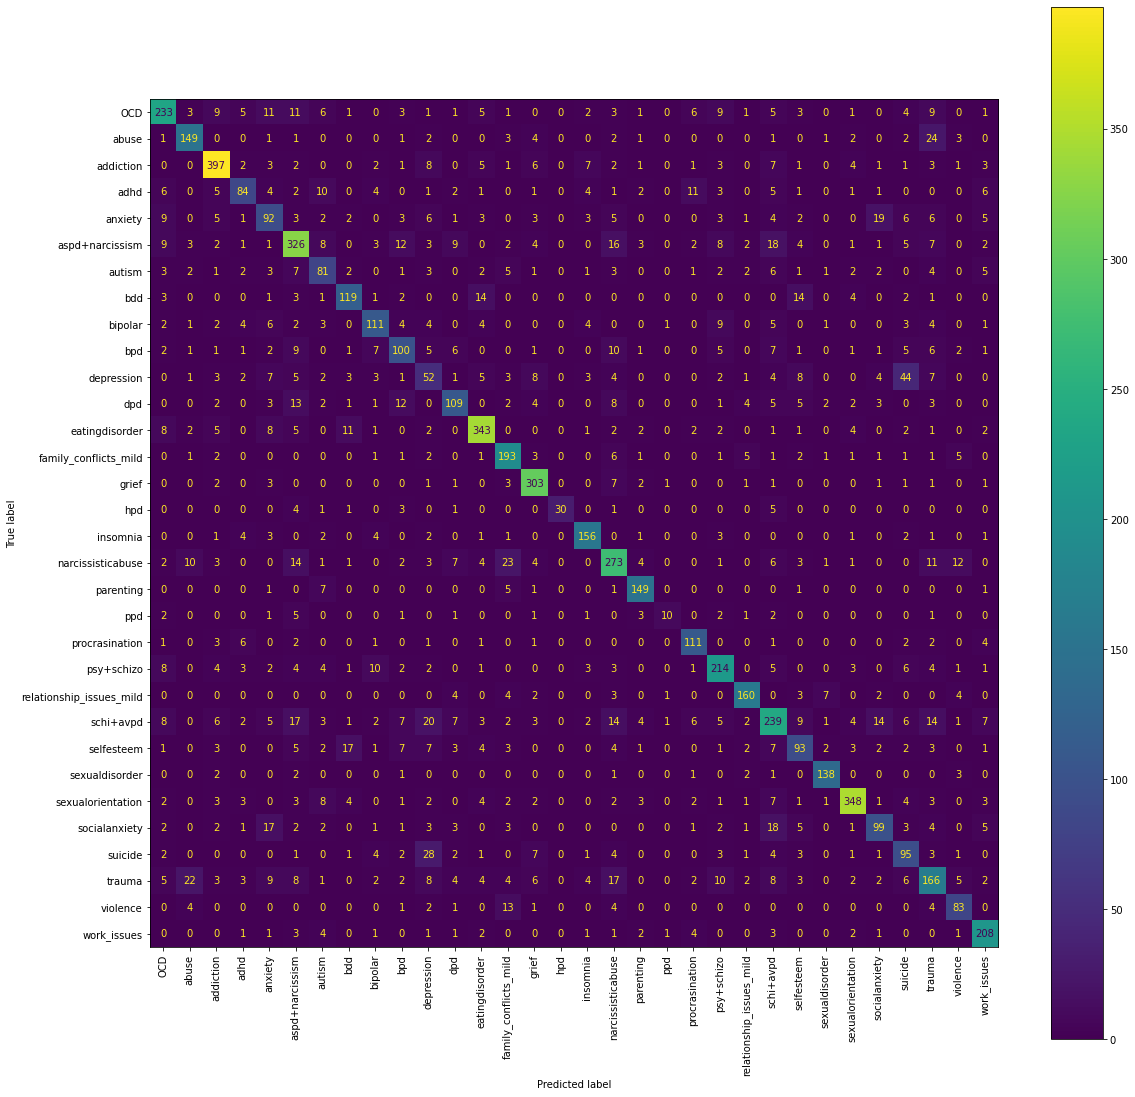

time: 2.9 s (started: 2022-08-08 22:00:33 +00:00)


In [13]:
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=labels)
fig, ax = plt.subplots(figsize=(19,19))
disp.plot(ax=ax,xticks_rotation = 'vertical')

In [14]:
dataset_pred= load_dataset('csv', data_files={'full': 'full_data.csv'})
tokenized_datasets_pred = dataset_pred.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_datasets_pred["full"])
preds_n = np.argmax(predictions.predictions, axis=-1)
y_true=train.labels.tolist()
y_pred_n=preds_n

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-3b9433885ebde22c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36661
  Batch size = 8


time: 10min 30s (started: 2022-08-08 22:00:35 +00:00)


In [15]:
from scipy.special import softmax
y_pred_s = softmax(predictions[0],axis = 1)

time: 10 ms (started: 2022-08-08 22:11:06 +00:00)


In [16]:
df[labels] = y_pred_s

time: 21.1 ms (started: 2022-08-08 22:11:06 +00:00)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [17]:
df = df.drop_duplicates(subset='text')
df.shape

(36661, 34)

time: 139 ms (started: 2022-08-08 22:11:06 +00:00)


In [18]:
df.head()

,text,labels,OCD,abuse,addiction,adhd,anxiety,aspd+narcissism,autism,bdd,...,relationship_issues_mild,schi+avpd,selfesteem,sexualdisorder,sexualorientation,socialanxiety,suicide,trauma,violence,work_issues
0,"what was it like? with whom? if not, what are ...",5,0.001144,0.000395,0.000370,0.000164,0.000142,0.951031,0.003125,0.000749,...,0.000106,0.024802,0.000416,0.000114,0.000734,0.000684,0.000311,0.001331,0.000070,0.000158
1,"i have no substantial relationships, hobbies, ...",10,0.002845,0.001720,0.001155,0.001265,0.002862,0.005240,0.001687,0.002099,...,0.000218,0.360733,0.001543,0.000197,0.001390,0.002266,0.024777,0.008107,0.000152,0.000610
2,"hi guys, i’m stuck in a bit of a rut here. for...",16,0.000472,0.000088,0.000967,0.000497,0.001584,0.000070,0.000099,0.000139,...,0.000082,0.000146,0.000051,0.000267,0.000183,0.000084,0.000473,0.000269,0.000292,0.000331
3,"tl:dr; living through a false self, didnt real...",5,0.005459,0.003240,0.001171,0.001336,0.002508,0.286840,0.004739,0.002550,...,0.001982,0.092808,0.021728,0.000318,0.002796,0.009040,0.061485,0.105705,0.002272,0.000552
4,my boyfriend of almost 8 months cheated on me ...,21,0.001465,0.000387,0.000113,0.000185,0.000301,0.000665,0.000206,0.000672,...,0.000797,0.000665,0.000223,0.000476,0.000625,0.000177,0.001453,0.000280,0.001326,0.000131


time: 21.1 ms (started: 2022-08-08 22:11:07 +00:00)


In [19]:
df['true_label'] = df['labels'].apply(lambda x: res[x])
df.head()

,text,labels,OCD,abuse,addiction,adhd,anxiety,aspd+narcissism,autism,bdd,...,schi+avpd,selfesteem,sexualdisorder,sexualorientation,socialanxiety,suicide,trauma,violence,work_issues,true_label
0,"what was it like? with whom? if not, what are ...",5,0.001144,0.000395,0.000370,0.000164,0.000142,0.951031,0.003125,0.000749,...,0.024802,0.000416,0.000114,0.000734,0.000684,0.000311,0.001331,0.000070,0.000158,aspd+narcissism
1,"i have no substantial relationships, hobbies, ...",10,0.002845,0.001720,0.001155,0.001265,0.002862,0.005240,0.001687,0.002099,...,0.360733,0.001543,0.000197,0.001390,0.002266,0.024777,0.008107,0.000152,0.000610,depression
2,"hi guys, i’m stuck in a bit of a rut here. for...",16,0.000472,0.000088,0.000967,0.000497,0.001584,0.000070,0.000099,0.000139,...,0.000146,0.000051,0.000267,0.000183,0.000084,0.000473,0.000269,0.000292,0.000331,insomnia
3,"tl:dr; living through a false self, didnt real...",5,0.005459,0.003240,0.001171,0.001336,0.002508,0.286840,0.004739,0.002550,...,0.092808,0.021728,0.000318,0.002796,0.009040,0.061485,0.105705,0.002272,0.000552,aspd+narcissism
4,my boyfriend of almost 8 months cheated on me ...,21,0.001465,0.000387,0.000113,0.000185,0.000301,0.000665,0.000206,0.000672,...,0.000665,0.000223,0.000476,0.000625,0.000177,0.001453,0.000280,0.001326,0.000131,psy+schizo


time: 26 ms (started: 2022-08-08 22:11:07 +00:00)


In [20]:
df['predicted_label'] = y_pred_n
df['predicted_label'] = df['predicted_label'].apply(lambda x: res[x])
df.head()

,text,labels,OCD,abuse,addiction,adhd,anxiety,aspd+narcissism,autism,bdd,...,selfesteem,sexualdisorder,sexualorientation,socialanxiety,suicide,trauma,violence,work_issues,true_label,predicted_label
0,"what was it like? with whom? if not, what are ...",5,0.001144,0.000395,0.000370,0.000164,0.000142,0.951031,0.003125,0.000749,...,0.000416,0.000114,0.000734,0.000684,0.000311,0.001331,0.000070,0.000158,aspd+narcissism,aspd+narcissism
1,"i have no substantial relationships, hobbies, ...",10,0.002845,0.001720,0.001155,0.001265,0.002862,0.005240,0.001687,0.002099,...,0.001543,0.000197,0.001390,0.002266,0.024777,0.008107,0.000152,0.000610,depression,depression
2,"hi guys, i’m stuck in a bit of a rut here. for...",16,0.000472,0.000088,0.000967,0.000497,0.001584,0.000070,0.000099,0.000139,...,0.000051,0.000267,0.000183,0.000084,0.000473,0.000269,0.000292,0.000331,insomnia,insomnia
3,"tl:dr; living through a false self, didnt real...",5,0.005459,0.003240,0.001171,0.001336,0.002508,0.286840,0.004739,0.002550,...,0.021728,0.000318,0.002796,0.009040,0.061485,0.105705,0.002272,0.000552,aspd+narcissism,aspd+narcissism
4,my boyfriend of almost 8 months cheated on me ...,21,0.001465,0.000387,0.000113,0.000185,0.000301,0.000665,0.000206,0.000672,...,0.000223,0.000476,0.000625,0.000177,0.001453,0.000280,0.001326,0.000131,psy+schizo,psy+schizo


time: 24 ms (started: 2022-08-08 22:11:07 +00:00)


In [21]:
df = df[['text', 'true_label', 'predicted_label']]
df.head()

,text,true_label,predicted_label
0,"what was it like? with whom? if not, what are ...",aspd+narcissism,aspd+narcissism
1,"i have no substantial relationships, hobbies, ...",depression,depression
2,"hi guys, i’m stuck in a bit of a rut here. for...",insomnia,insomnia
3,"tl:dr; living through a false self, didnt real...",aspd+narcissism,aspd+narcissism
4,my boyfriend of almost 8 months cheated on me ...,psy+schizo,psy+schizo


time: 11.8 ms (started: 2022-08-08 22:11:07 +00:00)


In [22]:
results = df
results[results['true_label'] == results['predicted_label']].shape[0]/results.shape[0]

0.8455306729221789

time: 10.2 ms (started: 2022-08-08 22:11:07 +00:00)


In [23]:
df_in = results[results['true_label'] != results['predicted_label']]
df_in.shape

(5663, 3)

time: 7.34 ms (started: 2022-08-08 22:11:07 +00:00)


In [24]:
df_in.to_csv('incorrect_dis.csv',index = False)

time: 119 ms (started: 2022-08-08 22:11:07 +00:00)


In [25]:
df.to_csv('full.csv', index = False)

time: 825 ms (started: 2022-08-08 22:11:07 +00:00)
